In [10]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import os
from pprint import pprint

import keras
import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import bounding_box, visualization

BATCH_SIZE = 2
IMAGE_SIZE = (256, 256)
BBOX_FORMAT = "xywh"

class_map = {
    0: "box",
    1: "green_light",
    2: "left_arrow",
    3: "no_light",
    4: "person",
    5: "red_light",
    6: "right_arrow",
    7: "tree",
    8: "unknown_arrow",
}

In [11]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True,
)

In [17]:
# Load the TFLite model and allocate tensors
# interpreter = tf.lite.Interpreter(model_path="mediapipe/exported_model/model.tflite")
interpreter = tf.lite.Interpreter(model_path="od_model.tflite")
# interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

interpreter.resize_tensor_input(input_details[0]["index"], (1, *IMAGE_SIZE, 3))

interpreter.allocate_tensors()

Input details: [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:1', 'index': 502, 'shape': array([1, 1, 9], dtype=int32), 'shape_signature': array([-1, -1,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 501, 'shape': array([ 1,  1, 64], dtype=int32), 'shape_signature': array([-1, -1, 64], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {

INFO: Created TensorFlow Lite delegate for select TF ops.
2024-05-02 12:17:53.289084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 12:17:53.289301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 12:17:53.289507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 12:17:53.289840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02

In [22]:
# Read and preprocess an image
image = tf.io.read_file("label_data/test/downloads_images/1709570998863_90_35.png")
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.float32)
image = np.array(image)
image = validation_resizing([image])
print(image)

print(image.shape)

tf.Tensor(
[[[[175.23438  179.98438  166.23438 ]
   [174.98438  179.92188  165.65625 ]
   [174.75     180.       164.875   ]
   ...
   [  8.25      10.25       9.25    ]
   [  9.421875  10.40625    9.71875 ]
   [  9.859375  10.234375   9.734375]]

  [[176.875    179.875    160.125   ]
   [174.45312  179.09375  160.04688 ]
   [172.8125   180.1875   162.3125  ]
   ...
   [  6.765625   9.         8.      ]
   [  7.15625   10.25       7.84375 ]
   [  7.75      11.5        8.25    ]]

  [[176.95312  179.32812  162.70312 ]
   [175.3125   179.09375  162.70312 ]
   [174.0625   180.1875   164.1875  ]
   ...
   [  7.390625   8.375      8.      ]
   [  7.390625   8.84375    8.234375]
   [  7.203125   9.078125   8.328125]]

  ...

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.    

array([[[ 2.9727652 ,  3.7267752 ,  4.432775  , ..., -0.86763823,
         -1.3820113 , -1.0641601 ],
        [ 3.7907991 ,  5.089338  ,  5.561413  , ..., -0.47456706,
         -1.1332738 , -0.85780954],
        [ 3.6348538 ,  3.8178    ,  5.035515  , ..., -0.2747439 ,
         -1.055436  , -0.7177233 ],
        ...,
        [ 0.13364649,  1.1267955 , -0.60618335, ...,  0.63741845,
          0.49077412,  0.19991933],
        [ 0.28521475,  0.72185665, -0.98605025, ...,  0.22677101,
          0.34056166,  0.15786599],
        [-0.06757154,  0.03961808, -0.4319521 , ...,  0.18066165,
          0.11403021,  0.7420153 ]]], dtype=float32)
(1, 1344, 64)
Time: 0.20032167434692383


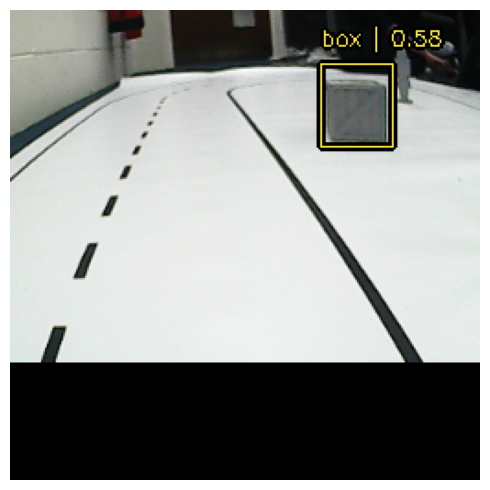

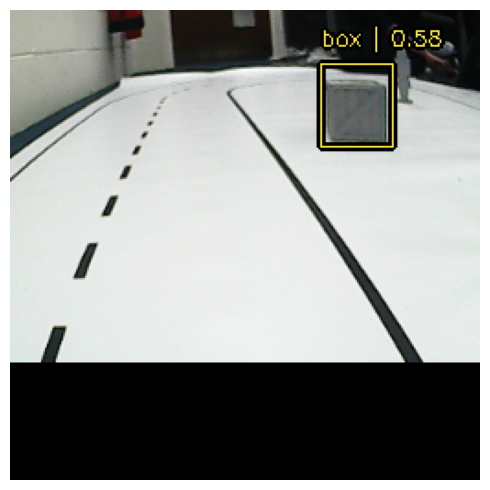

In [21]:
import time

yolomodel = keras_cv.models.YOLOV8Detector(
    num_classes=9,
    bounding_box_format=BBOX_FORMAT,
    fpn_depth=2,
    backbone=keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone"),
)
yolomodel.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.5,  # Minimum IOU for two boxes to be considered the same
    confidence_threshold=0.501,  # Minimum confidence for a box to be considered a detection
    max_detections=8,  # Maximum number of detections to keep
)
t1 = time.time()
interpreter.set_tensor(input_details[0]["index"], image)
interpreter.invoke()

y_pred = {
    "classes": interpreter.get_tensor(output_details[0]["index"]),
    "boxes": interpreter.get_tensor(output_details[1]["index"]),
}


# y_pred2 = model.call(image)

# print(type(y_pred["boxes"]))

pprint(y_pred["boxes"])
print(y_pred["boxes"].shape)


y_pred_decoded = yolomodel.decode_predictions(y_pred, image)
t2 = time.time()

print(f"Time: {t2-t1}")

# print(y_pred_decoded)


# pprint(y_pred)

# y_pred_print = y_pred.copy()
# y_pred_print["classes"] = [class_map[i] for i in y_pred["classes"].flatten() if i != -1]
# pprint(y_pred_print)
# """Format:
# {'boxes': [[x_left, y_top, width, height], ...],
#  'classes': [class_id, ...],
#  'confidence': [confidence, ...]
#  'num_detections': [int]}
# """

keras_cv.visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred_decoded,
    scale=5,
    font_scale=0.4,
    line_thickness=1,
    bounding_box_format=BBOX_FORMAT,
    class_mapping=class_map,
)